## Day 9

https://adventofcode.com/2025/day/9#part2

### Part 1

In [1]:
def read_input_9(filename):
    with open(filename) as f:
        return [[int(x) for x in l.split(",")] for l in f.readlines()]

In [2]:
def area(X1,X2):
    x1,y1 = X1
    x2,y2 = X2
    dx = abs(x1-x2)+1
    dy = abs(y1-y2)+1
    return dx*dy

def part1(filename):
    coord = read_input_9(filename)
    areas = []
    for i in range(len(coord)):
        X1 = coord[i]
        for j in range(i+1,len(coord)):
            X2 = coord[j]
            areas.append(area(X1,X2))
    return max(areas)

In [3]:
print("Test 1:",part1("examples/example09.txt"))
print("Part 1:",part1("AOC2025inputs/input09.txt"))

Test 1: 50
Part 1: 4744899849


### Part 2

First check whether coordinates are continous, so that I can simply build the edges of the tile polygon:

In [4]:
def check_continuity(coord, verbose=False):
    x0,y0 = coord[0]
    for x,y in coord[1:]:
        if x!=x0 and y!=y0:
            return False
        x0, y0 = x, y
    return True

coord0 = read_input_9("examples/example09.txt")
print("Example is continuos?", check_continuity(coord0,True))

coord = read_input_9("AOC2025inputs/input09.txt")
print("Input is continuos?", check_continuity(coord,False))

Example is continuos? True
Input is continuos? True


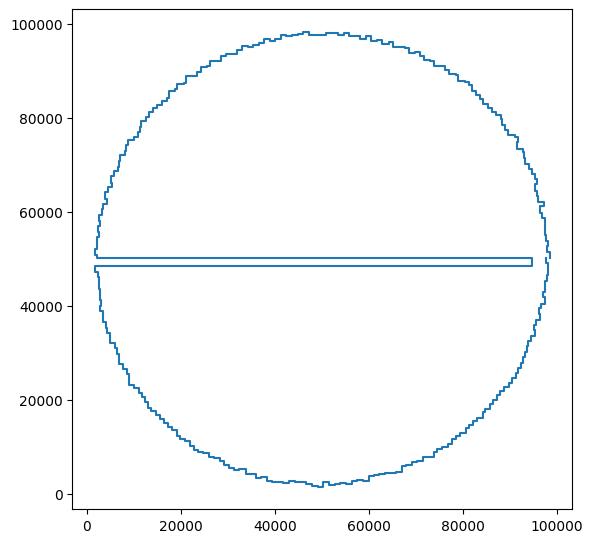

In [5]:
import numpy as np
import matplotlib.pyplot as plt

coord = read_input_9("AOC2025inputs/input09.txt")

c = np.array(coord)
x, y = c.T

f = plt.figure(figsize=(5,5),dpi=100)
ax = f.add_axes([0, 0, 1, 1])
plt.plot(x,y,"-")
plt.show()

#### Strategy

* Find horizontal and vertical edges of tile polygon, assuming coordinate continuity.
* Build all rectangles as in Part 1, check whether rectable is within polygon, compute area.
* Return largest area

#### How to check whether rectangle is within polygon?

* Rectangle vertices must be all be in coordinate lists, or vertices not on initial list must be *inside* the polygon
   * Initially implemented a [point-in-polygon test](https://en.wikipedia.org/wiki/Point_in_polygon) to check whether the rectangle vertices were within the polygon: this alone fails if there are concavities on the polygon perimeter.
* Additional check: verify whether rectangle edges cross polygon edges.

In [6]:
def find_edges(coord):
    """ 
    Find horizontal and vertical edges connecting consecutive red tiles.
    """
    x0, y0 = coord[0]
    horizontal = []
    vertical = []
    for x, y in coord[1:] + [coord[0]]:
        if x == x0: # vertical edge at x
            ys = sorted((y0, y))
            vertical.append((x, ys[0], ys[1]))
        else: # horizontal edge at y
            xs = sorted((x0, x))
            horizontal.append((y, xs[0], xs[1]))
        x0, y0 = x, y
    return horizontal, vertical

def point_in_polygon(point, vertical_edges):
    """
    Cast a ray from point to the left and count how many times it crosses vertical edges.
    Odd number of crossings = inside, even = outside.
    """
    x, y = point
    crossings = 0
    for xe, y1, y2 in vertical_edges:
        if y1 <= y < y2 and xe < x:
            crossings += 1
    return crossings % 2 == 1

def rectangle_boundaries(X1, X2):
    """
    Get rectangle borndaries from vertex pair.
    """
    x1, y1 = X1
    x2, y2 = X2
    x_min = min(x1, x2)
    x_max = max(x1, x2)
    y_min = min(y1, y2)
    y_max = max(y1, y2)
    return x_min, x_max, y_min, y_max 

def is_rectangle_valid(X1, X2, coord, vertical_edges, horizontal_edges):
    """
    Check if a rectangle with corners at X1 and X2 is inside polygon defined by tile coordinates
    A rectangle is valid if:
    - All four corners on the polygon boundary (check agains coordinate list) or inside the polygon (check with ray casting)
    - No polygon edges cross through the interior of the rectangle (check edges crossings)
    """
    x_min, x_max, y_min, y_max = rectangle_boundaries(X1, X2)
    corners = [ (x_min, y_min), (x_min, y_max), (x_max, y_min), (x_max, y_max) ]
    
    # Check that all corners are inside or on the boundary (red tiles)
    for corner in corners:
        if corner not in coord:
            # Corner is not a red tile, so check if it's inside the polygon
            if not point_in_polygon(corner, vertical_edges):
                return False
    
    # Check that no polygon edges cross through the interior of the rectangle
    # (both horizontal and vertical edges of the polygon)
    
    # Check horizontal polygon edges
    for y_edge, x_start, x_end in horizontal_edges:
        if y_min < y_edge < y_max: # y-coordinate is strictly between y_min and y_max (not on boundary)
            if not (x_end <= x_min or x_start >= x_max): # edge crosses through rectangle
                return False
    
    # Check vertical polygon edges
    for x_edge, y_start, y_end in vertical_edges:
        if x_min < x_edge < x_max: # x-coordinate is strictly between x_min and x_max (not on boundary)
            if not (y_end <= y_min or y_start >= y_max): # edge crosses through rectangle
                return False
    
    return True

In [7]:
def part2(filename):
    coord = read_input_9(filename)
    
    # Find the edges of the polygon formed by red tiles
    horizontal, vertical = find_edges(coord)
    
    # Create coordinate set for faster lookup of red tiles
    coord_set = set(tuple(c) for c in coord)
    
    max_area = 0
    
    # Try all pairs of red tiles as opposite corners
    for i in range(len(coord)):
        X1 = coord[i]
        for j in range(i + 1, len(coord)):
            X2 = coord[j]
            
            # Check if this rectangle is valid
            if is_rectangle_valid(X1, X2, coord_set, vertical, horizontal):
                current_area = area(X1, X2)
                max_area = max(max_area, current_area)
    
    return max_area

In [8]:
print("Test 2:",part2("examples/example09.txt"))
print("Part 2:",part2("AOC2025inputs/input09.txt"))

Test 2: 24
Part 2: 1540192500
